<a href="https://colab.research.google.com/github/alvinrach/23-Computer-Vision-Rock-Paper-Scissor/blob/main/23_Computer_Vision_Rock_Paper_Scissor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Name: Alvin Rachmat**

**Project: Computer Vison - Predict Rock, Paper or Scissor Hand Image**

In [1]:
!wget --no-check-certificate \
  https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip \
  -O /content/rockpaperscissors.zip

--2021-07-27 05:08:47--  https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip
Resolving dicodingacademy.blob.core.windows.net (dicodingacademy.blob.core.windows.net)... 52.239.197.36
Connecting to dicodingacademy.blob.core.windows.net (dicodingacademy.blob.core.windows.net)|52.239.197.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 322873683 (308M) [application/zip]
Saving to: ‘/content/rockpaperscissors.zip’

/content/rockpapers 100%[===================>] 307.92M  7.74MB/s    in 63s     

2021-07-27 05:09:52 (4.86 MB/s) - ‘/content/rockpaperscissors.zip’ saved [322873683/322873683]



In [2]:
import zipfile, os
local_zip = '/content/rockpaperscissors.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
# import random
# random_number = random.randint(0, 100)
# print(random_number)

dir='/content/rockpaperscissors/rps-cv-images'

# Input resolution is 200x300 refer to the readme note on the data
# Scaling down the image is done for faster computation's sake
# But here we'll use the number that usually used in journals (224x224)
target_img = (224, 224)
batch = 1
set_seed = 38 #random_number

# Image augmentation

datagen=ImageDataGenerator(
                    rescale=1./255,

                    # Rotate the image in the 40 degree range
                    rotation_range=40,

                    # Flipping the image
                    horizontal_flip=True,
                    vertical_flip=True, 

                    # Shfiting the image
                    width_shift_range=0.2, 
                    height_shift_range=0.2, 

                    # Shear transformation or skewing the image
                    shear_range = 0.2,

                    # Zoom in range 0.8-1.2x
                    zoom_range=0.2,
                    
                    # Brightness in range 90%-100%
                    brightness_range=[0.9,1.0], 

                    # Filling method that is used after doing some augmentation
                    fill_mode = 'nearest',
                    
                    # 40% data as the validation data and the rest are in the training data
                    validation_split=0.4
                    )

train_generator = datagen.flow_from_directory(
        dir,  # Photo directory
        target_size=target_img,
        batch_size=batch,
        class_mode='categorical', # Three category classification
        subset='training',
        seed=set_seed
        )

# Separated generator to avoid mixing of the train-test data, set same seed
datagenval = ImageDataGenerator(
                    rescale=1./255,
                    validation_split=0.4
                    )

validation_generator = datagenval.flow_from_directory(
        dir,
        target_size=target_img,
        batch_size=batch,
        class_mode='categorical',
        subset='validation',
        seed=set_seed
        )

Found 1314 images belonging to 3 classes.
Found 874 images belonging to 3 classes.


In [5]:
# from tensorflow.keras.applications import InceptionV3

model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer((*target_img,3)),
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same'), # The filter is increased bt the multiplication of two, to maximalize the GPU performance in a layer
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(512, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(1024, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(2,2),
   
    # InceptionV3(weights="imagenet", include_top=False),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation='relu'), # In general CNN uses just two Fully Connected layer (a hidden layer an an output layer)
    tf.keras.layers.Dense(3, activation='softmax') # Since the output isn't binary, don't use sigmoid. Here I use softmax function
])

# model.layers[0].trainable = False

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 128)       7

In [7]:
model.compile(loss='categorical_crossentropy',

              optimizer='sgd', # Adam is faster and good enough, SGD slower thatn Adam but it generalizes better
              # https://www.tensorflow.org/api_docs/python/tf/keras/optimizers
              
              metrics=['accuracy']
              )

In [8]:
import math

# Callback to stop run based on epoch patience
# early = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=15)

# Callback to save model/best epoch
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'model.h5',
    monitor = 'val_accuracy',
    save_best_only = True,
    verbose = 1
)

# Callback to reduce LR based on epoch patience
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor = 'val_accuracy',
    patience = 10,
    factor = 0.1,
    min_lr = 1e-4,
    verbose = 1
)

# Callback to stop run when reach a value
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy')==1):
            print("\nMaximum Validtion Accuracy has reached!")
            self.model.stop_training = True
callback = myCallback()

set_callback = [checkpoint, reduce_lr, callback]#, early]

tf.random.set_seed(set_seed)

history = model.fit(
      train_generator,
      epochs = 70,
      validation_data=validation_generator,
      callbacks=set_callback,
      verbose = 1
      )

Epoch 1/70
1314/1314 [==============================] - 63s 24ms/step - loss: 1.1012 - accuracy: 0.3227 - val_loss: 1.0989 - val_accuracy: 0.3432

Epoch 00001: val_accuracy improved from -inf to 0.34325, saving model to model.h5
Epoch 2/70
1314/1314 [==============================] - 31s 24ms/step - loss: 1.0869 - accuracy: 0.3767 - val_loss: 1.1179 - val_accuracy: 0.3455

Epoch 00002: val_accuracy improved from 0.34325 to 0.34554, saving model to model.h5
Epoch 3/70
1314/1314 [==============================] - 31s 24ms/step - loss: 0.7536 - accuracy: 0.6537 - val_loss: 0.6869 - val_accuracy: 0.6854

Epoch 00003: val_accuracy improved from 0.34554 to 0.68535, saving model to model.h5
Epoch 4/70
1314/1314 [==============================] - 32s 24ms/step - loss: 0.4811 - accuracy: 0.8044 - val_loss: 0.2378 - val_accuracy: 0.9268

Epoch 00004: val_accuracy improved from 0.68535 to 0.92677, saving model to model.h5
Epoch 5/70
1314/1314 [==============================] - 30s 23ms/step - los

In [10]:
# Model must be loaded, else it will use the last epoch accuracy
model.load_weights("model.h5")
model.evaluate(validation_generator, verbose=2)

874/874 - 4s - loss: 0.0019 - accuracy: 1.0000


[0.001889511477202177, 1.0]

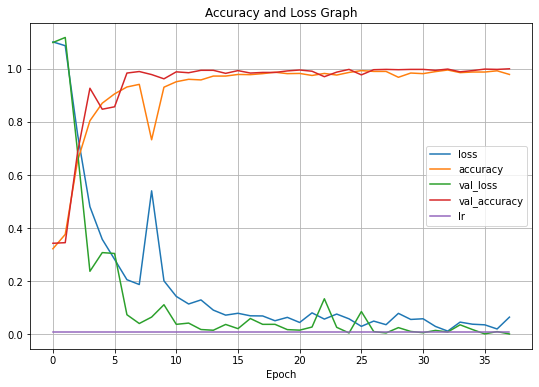

In [11]:
# Plotting the loss and accuracy performance in the every epoch
import pandas as pd
import matplotlib.pyplot as plt
pd.DataFrame(history.history).plot(figsize=(9,6))
plt.xlabel('Epoch')
plt.title('Accuracy and Loss Graph')
plt.grid()

In [12]:
import numpy as np
from google.colab import files
from keras.preprocessing import image
import matplotlib.image as mpimg

def predict():
  i=''

  while(i==''):
    uploaded=files.upload()

    for fn in uploaded.keys():
      path = fn
      img = image.load_img(path, target_size=target_img)
      imgplot = plt.imshow(img)
      x = image.img_to_array(img)
      x = np.expand_dims(x, axis=0)

      images = np.vstack([x])
      classes = model.predict(images, batch_size=10)
      # Since we use categorical_crossentropy in the loss parameter at model.compile,
      # Translate the result with argmax: returns the index which has the max values
      j = np.argmax(classes)
      
      print(classes)
      print(fn)

      if j==0:
        print('Paper')
      elif j==1:
        print('Rock')
      elif j==2:
        print('Scissor')

    i=input('Again? [(yes: enter) / (no: ~enter)]')

Saving photo_2021-05-20_02-34-45.jpg to photo_2021-05-20_02-34-45.jpg
[[0. 0. 1.]]
photo_2021-05-20_02-34-45.jpg
Scissor
Again? [(yes: enter) / (no: ~enter)]n


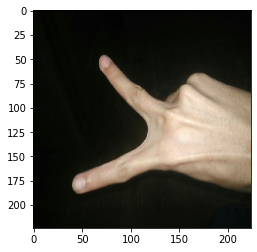

In [13]:
predict()

Saving photo_2021-05-20_02-34-47.jpg to photo_2021-05-20_02-34-47.jpg
[[0. 1. 0.]]
photo_2021-05-20_02-34-47.jpg
Rock
Again? [(yes: enter) / (no: ~enter)]no


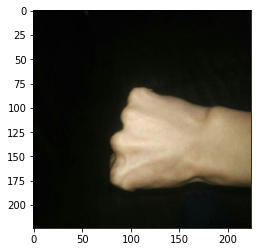

In [14]:
predict()

Saving photo_2021-05-20_01-31-21.jpg to photo_2021-05-20_01-31-21.jpg
[[1. 0. 0.]]
photo_2021-05-20_01-31-21.jpg
Paper
Again? [(yes: enter) / (no: ~enter)]t


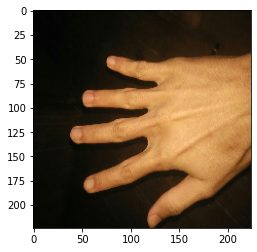

In [15]:
predict()